In [1]:
import time

import itk
import numpy as np
import matplotlib.pyplot as plt

In [2]:
itk.VkGlobalConfiguration.SetDeviceID(1)

default_num_threads = itk.MultiThreaderBase.GetGlobalDefaultNumberOfThreads()

In [3]:
pixel_type = itk.F
dimension = 3
image_type = itk.Image[pixel_type,dimension]
region_type = itk.ImageRegion[dimension]

In [4]:
def time_filter(itk_filter) -> float:
    starttime = time.time()
    itk_filter.Update()
    endtime = time.time()
    return endtime - starttime

def setup_gaussian_filter(gaussian_filter, image:image_type, region:region_type):
    gaussian_filter.SetInput(image)
    gaussian_filter.SetVariance(25.0)
    gaussian_filter.SetMaximumError(0.001)
    gaussian_filter.SetMaximumKernelWidth(25)
    gaussian_filter.GetOutput().SetRequestedRegion(region)

In [5]:
def time_separable_gaussian_filter(image:image_type, region:region_type) -> float:
    separable_filter = itk.DiscreteGaussianImageFilter[type(image),type(image)].New()
    setup_gaussian_filter(separable_filter, image, region)    
    return time_filter(separable_filter)
    
def time_fft_gaussian_filter(image:image_type, region:region_type) -> float:
    fft_filter = itk.FFTDiscreteGaussianImageFilter[type(image),type(image)].New()
    setup_gaussian_filter(fft_filter, image, region)    
    return time_filter(fft_filter)

In [6]:
import os
os.getpid()

5504

In [7]:
def count_region(region:itk.ImageRegion[3]) -> int:
    return region.GetSize()[0] * region.GetSize()[1] * region.GetSize()[2]

In [9]:
ratios = [1.0, 0.9, 0.8, 0.6, 0.4]
image_size = [500] * 3

In [40]:
data = np.zeros([4,len(ratios)])

itk.MultiThreaderBase.SetGlobalDefaultNumberOfThreads(default_num_threads)

# Variable image size, requested region == largest possible region
for idx, dim_ratio in enumerate(ratios):
    adjusted_image_size = [int(image_size[dim] * dim_ratio) for dim in range(3)]
    image = itk.image_from_array(np.random.rand(*adjusted_image_size).astype(np.float32))
    largest_possible_region = image.GetLargestPossibleRegion()
    
    separable_time = time_separable_gaussian_filter(image, largest_possible_region)
    fft_time = time_fft_gaussian_filter(image, largest_possible_region)

    print(f'{dim_ratio} per dim == {largest_possible_region.GetSize()[0]}px per side'
          f' == {(dim_ratio ** 3):0.4f} vol == {count_region(largest_possible_region):0.4e}px total')
    print(f'\t\t-> vnl {separable_time:0.3f}s fft: {fft_time:0.3f}s')

    data[0,idx] = separable_time
    data[1,idx] = fft_time
    
# Fixed image size, requested region == (ratio ** 3) * largest possible region
for idx, dim_ratio in enumerate(ratios):
    image = itk.image_from_array(np.random.rand(*image_size).astype(np.float32))
    
    region_size = [int(dim_ratio * image_size[dim]) for dim in range(3)]
    region_index = [int((image_size[dim] - region_size[dim]) / 2) for dim in range(3)]
    requested_output_region = region_type(region_index, region_size)
    
    separable_time = time_separable_gaussian_filter(image, requested_output_region)
    fft_time = time_fft_gaussian_filter(image, requested_output_region)

    print(f'{dim_ratio} per dim == {region_size[0]}px per side'
          f' == {(dim_ratio ** 3):0.2%} vol == {(region_size[0] * region_size[1] * region_size[2]):0.4e}px total')
    print(f'\t\t-> vnl {separable_time:0.3f}s fft: {fft_time:0.3f}s')

    data[2,idx] = separable_time
    data[3,idx] = fft_time

1.0 per dim == 500px per side == 1.0000 vol == 1.2500e+08px total
		-> vnl 81.851s fft: 17.852s
0.9 per dim == 450px per side == 0.7290 vol == 9.1125e+07px total
		-> vnl 63.262s fft: 12.687s
0.8 per dim == 400px per side == 0.5120 vol == 6.4000e+07px total
		-> vnl 50.426s fft: 9.476s
0.6 per dim == 300px per side == 0.2160 vol == 2.7000e+07px total
		-> vnl 27.462s fft: 4.681s
0.4 per dim == 200px per side == 0.0640 vol == 8.0000e+06px total
		-> vnl 10.838s fft: 1.850s
1.0 per dim == 500px per side == 1.0000 vol == 1.2500e+08px total
		-> vnl 84.346s fft: 18.121s
0.9 per dim == 450px per side == 0.7290 vol == 9.1125e+07px total
		-> vnl 21.793s fft: 17.635s
0.8 per dim == 400px per side == 0.5120 vol == 6.4000e+07px total
		-> vnl 15.608s fft: 17.761s
0.6 per dim == 300px per side == 0.2160 vol == 2.7000e+07px total
		-> vnl 7.359s fft: 17.662s
0.4 per dim == 200px per side == 0.0640 vol == 8.0000e+06px total
		-> vnl 2.074s fft: 17.157s


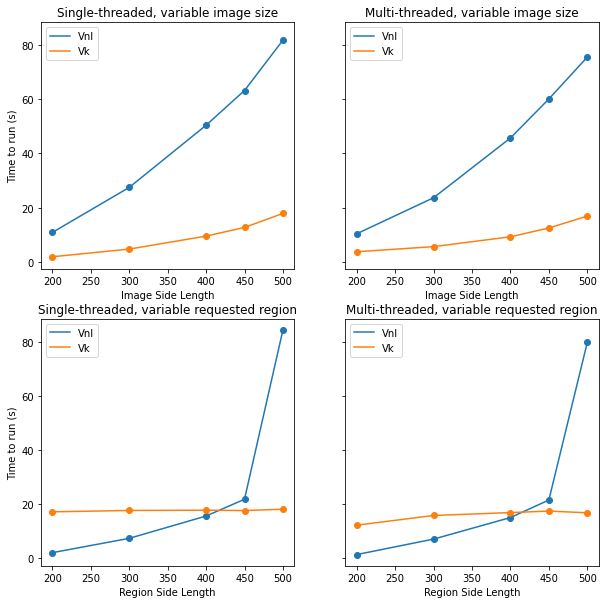

In [10]:
singlethreaded_data = np.loadtxt("data/output/blur-benchmark-singlethreaded.csv",delimiter=",")
multithreaded_data = np.loadtxt("data/output/blur-benchmark-multithreaded.csv",delimiter=",")

fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(10,10),sharey=True)
region_lengths = [ratios[idx] * image_size[0] for idx,_ in enumerate(ratios)]

for threading_type in range(2):
    for region_type in range(2):
        ax = axs[region_type,threading_type]
        data = singlethreaded_data if threading_type == 0 else multithreaded_data
        
        for backend_type in range(2):
            ax.plot(region_lengths, data[2 * region_type + backend_type])
            ax.scatter(region_lengths, data[2 * region_type + backend_type])
        
        ax.set_xlabel('Image Side Length' if region_type == 0 else 'Region Side Length')
        ax.legend(['Vnl','Vk'])

axs[0,0].set_title('Single-threaded, variable image size')
axs[0,1].set_title('Multi-threaded, variable image size')
axs[1,0].set_title('Single-threaded, variable requested region')
axs[1,1].set_title('Multi-threaded, variable requested region')

for ax in axs[:,0]:
    ax.set_ylabel('Time to run (s)')
        
plt.show()

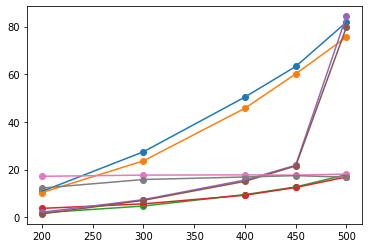

In [12]:
for idx in range(4):
    plt.plot(region_lengths,singlethreaded_data[idx])
    plt.scatter(region_lengths,singlethreaded_data[idx])
    plt.plot(region_lengths,multithreaded_data[idx])
    plt.scatter(region_lengths,multithreaded_data[idx])